In [23]:
%matplotlib inline

import pandas as pd
import itertools

from utils import get_mongo_db

Let's first get the MongoDB instance

In [24]:
db = get_mongo_db()

Connecting to MongoDB at localhost:27017...


Let's now compute the number of repositories per language (keeping in mind that the `repositories` collection contains both repositories owned by our Swiss users, but also any repository that they starred. It's thus a pretty big collection).

In [3]:
db.repositories.count()

134092

Let's first do the aggregation manually in Python:

In [4]:
repos = db.repositories.find({ 'language': { '$ne': None } }, { 'language': True })
repos.count()

124254

In [5]:
repos[0]

{'_id': 24002363, 'language': 'JavaScript'}

In [6]:
counts = {}
for repo in repos:
    if repo['language'] not in counts:
        counts[repo['language']] = 0
    counts[repo['language']] += 1

In [7]:
data = [{ 'language': lang, 'count': counts[lang] } for lang in counts]
df = pd.DataFrame(data).set_index('language')
df.sort_values(by='count', ascending=False)[0:10]

count
language          
JavaScript   26903
Python       14709
PHP           9838
Java          9196
Ruby          9157
C             6004
C++           5702
Objective-C   4519
Shell         4198
Go            3627

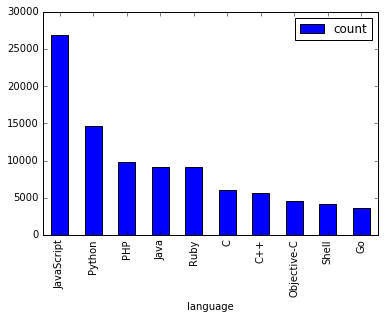

In [8]:
df.sort_values(by='count', ascending=False)[0:10].plot(kind='bar')

Let's now use a potentially more efficient method, using MongoDB's aggregation framework:

In [9]:
from bson.son import SON

In [10]:
pipeline = [
    {
        '$match': {
            'language': { '$ne': None }
        }
    },
    {
        '$group': {
            '_id': '$language',
            'count': { '$sum': 1 }
        }
    },
    {
        '$sort': SON([('count', -1), ('_id', -1)])
    }
]


data = list(db.repositories.aggregate(pipeline))

In [11]:
df = pd.DataFrame(data).rename(columns={ '_id': 'language' }).set_index('language')
df.sort_values(by='count', ascending=False)[0:10]

count
language          
JavaScript   26903
Python       14713
PHP           9838
Java          9197
Ruby          9169
C             6004
C++           5702
Objective-C   4519
Shell         4202
Go            3630

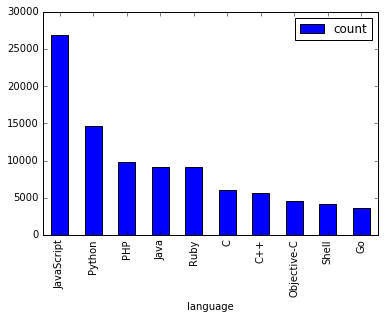

In [12]:
df.sort_values(by='count', ascending=False)[0:10].plot(kind='bar')

Alright, let's now try to retrieve all the Swiss users and their repositories:

In [43]:
res = db.users.find({ 'in_ch': True, 'repositories': { '$ne': None } })

users = []

for user in res:
    repos = db.repositories.find(
        { '_id': { '$in': user['repositories'] } }
    )
    
    users.append({
        '_id': user['_id'],
        'login': user['login'],
        'name': user['name'],
        'location': user['location'],
        'repositories_docs': list(repos)
    })

In [45]:
len(users)

3077

In [46]:
users[1]

{'_id': 183678,
 'location': 'Zürich, Zurich, Switzerland',
 'login': 'Seldaek',
 'name': 'Jordi Boggiano',
 'repositories_docs': [{'_id': 546522,
   'clone_url': 'https://github.com/Seldaek/phergie.git',
   'created_at': datetime.datetime(2010, 3, 4, 12, 46, 24),
   'fork': True,
   'forks_count': 1,
   'full_name': 'Seldaek/phergie',
   'has_downloads': False,
   'has_issues': False,
   'has_pages': False,
   'homepage': 'http://phergie.org',
   'language': 'PHP',
   'name': 'phergie',
   'open_issues': 0,
   'open_issues_count': 0,
   'owner_id': 183678,
   'private': False,
   'size': 324,
   'stargazers_count': 3,
   'watchers_count': 3},
  {'_id': 568030,
   'clone_url': 'https://github.com/Seldaek/Dwoo.git',
   'created_at': datetime.datetime(2010, 3, 18, 10, 40, 47),
   'fork': False,
   'forks_count': 16,
   'full_name': 'Seldaek/Dwoo',
   'has_downloads': True,
   'has_issues': True,
   'has_pages': False,
   'homepage': '',
   'language': 'PHP',
   'name': 'Dwoo',
   'open_i

Let's now try using MongoDB's aggregation framework:

In [47]:
pipeline = [
    {
        '$match': { 'in_ch': True, 'repositories': { '$ne': None } }
    },
    {
        '$lookup': {
            'from': 'repositories',
            'localField': '_id',
            'foreignField': 'owner_id',
            'as': 'repositories_docs'
        }
    },
    {
        '$project': {
            'login': True,
            'name': True,
            'location': True,
            'repositories_docs': True
        }
    }
]

data = list(db.users.aggregate(pipeline))

In [48]:
len(data)

3077

In [49]:
data[1]

{'_id': 183678,
 'location': 'Zürich, Zurich, Switzerland',
 'login': 'Seldaek',
 'name': 'Jordi Boggiano',
 'repositories_docs': [{'_id': 6427443,
   'clone_url': 'https://github.com/Seldaek/ActivDevNoclineBundle.git',
   'created_at': datetime.datetime(2012, 10, 28, 12, 50, 43),
   'fork': True,
   'forks_count': 0,
   'full_name': 'Seldaek/ActivDevNoclineBundle',
   'has_downloads': True,
   'has_issues': False,
   'has_pages': False,
   'homepage': '',
   'language': 'PHP',
   'name': 'ActivDevNoclineBundle',
   'open_issues': 0,
   'open_issues_count': 0,
   'owner_id': 183678,
   'private': False,
   'size': 182,
   'stargazers_count': 4,
   'watchers_count': 4},
  {'_id': 24607470,
   'clone_url': 'https://github.com/Seldaek/alice.git',
   'created_at': datetime.datetime(2014, 9, 29, 18, 29, 20),
   'fork': True,
   'forks_count': 0,
   'full_name': 'Seldaek/alice',
   'has_downloads': True,
   'has_issues': False,
   'has_pages': False,
   'homepage': None,
   'language': None,

We can now try to get the list of all the repositories owned by a Swiss user:

In [8]:
ch_users = db.users.find({ 'in_ch': True }, { '_id': True })
ch_users_ids = [u['_id'] for u in ch_users]

In [11]:
pipeline = [
    {
        '$match': { 'owner_id': { '$in': ch_users_ids } }
    }
]

data = list(db.repositories.aggregate(pipeline))

In [12]:
len(data)

98862

In [29]:
data[1]

{'_id': 45470702,
 'clone_url': 'https://github.com/vhf/babel.git',
 'created_at': datetime.datetime(2015, 11, 3, 14, 9, 12),
 'fork': True,
 'forks_count': 1,
 'full_name': 'vhf/babel',
 'has_downloads': True,
 'has_issues': False,
 'has_pages': False,
 'homepage': 'https://babeljs.io/',
 'language': 'JavaScript',
 'name': 'babel',
 'open_issues': 0,
 'open_issues_count': 0,
 'owner_id': 2022803,
 'private': False,
 'size': 12828,
 'stargazers_count': 0,
 'watchers_count': 0}

Alternatively:

In [32]:
pipeline = [
    {
        '$match': { 'in_ch': True, 'repositories': { '$ne': None } }
    },
    {
        '$lookup': {
            'from': 'repositories',
            'localField': '_id',
            'foreignField': 'owner_id',
            'as': 'repositories_docs'
        }
    },
    {
        '$unwind': '$repositories_docs'
    },
    {
        '$replaceRoot': { 'newRoot': '$repositories_docs' }
    }
]

data = list(db.users.aggregate(pipeline))
len(data)

98862

In [33]:
data[0]

{'_id': 24002363,
 'clone_url': 'https://github.com/vhf/absorb.git',
 'created_at': datetime.datetime(2014, 9, 13, 18, 38, 2),
 'fork': False,
 'forks_count': 1,
 'full_name': 'vhf/absorb',
 'has_downloads': True,
 'has_issues': True,
 'has_pages': True,
 'homepage': None,
 'language': 'JavaScript',
 'name': 'absorb',
 'open_issues': 0,
 'open_issues_count': 0,
 'owner_id': 2022803,
 'private': False,
 'size': 5,
 'stargazers_count': 1,
 'watchers_count': 1}

For the record, the above aggregation query is available as a read-only view, called `ch_repositories_view`:

In [34]:
data = list(db.ch_repositories_view.find())
len(data)

98862

In [35]:
data[0]

{'_id': 24002363,
 'clone_url': 'https://github.com/vhf/absorb.git',
 'created_at': datetime.datetime(2014, 9, 13, 18, 38, 2),
 'fork': False,
 'forks_count': 1,
 'full_name': 'vhf/absorb',
 'has_downloads': True,
 'has_issues': True,
 'has_pages': True,
 'homepage': None,
 'language': 'JavaScript',
 'name': 'absorb',
 'open_issues': 0,
 'open_issues_count': 0,
 'owner_id': 2022803,
 'private': False,
 'size': 5,
 'stargazers_count': 1,
 'watchers_count': 1}

In [78]:
data = list(db.users.find(
    {'in_ch': True, 'location': { '$ne': None }, 'geocode': None },
    { 'location': True }
))

In [79]:
len(data)

35

In [80]:
data[0]

{'_id': 756703, 'location': 'From GER, now in CH'}

In [81]:
locations = set([loc['location'] for loc in data])
len(locations)

35

In [82]:
df = pd.DataFrame([{'location': loc} for loc in locations]).sort_values(by='location').reset_index()

In [83]:
df

index                                           location
0      12                                          /var/log/
1      11                5/23 VALMIKI ST EAST TAMBARAM CH-59
2      14                                          Bookspage
3      19          Bottighofen, CH & Munich, DE & Poznan, PL
4      13                                           CH GD SZ
5      20       D4 Business Center, Root Längenbold, CH-6037
6       2  Delaware, USA | Melbourne, AU | Zug, CH | Shan...
7      18  Espace Gruyère SA Rue de Vevey 136-144 Case po...
8      25                                From GER, now in CH
9      32                 HANGZHOU ZHEJIANG CH / CHICAGO, US
10     26                                           HZ,zj,CH
11     22                                          Location:
12      0        Milano - Como - Siderno (IT) | Chiasso (CH)
13      4                                    NP, HK, UK & CH
14      9                                 NY, ON, CH, PB, SF
15     33                                 New York, New York
16     10                      Novosibirsk RU, Winterthur CH
17     24  Platz 5, D4 Business Center, Root Längenbold, ...
18     34                                             SH. ZH
19     21                                   Schwellheim / CH
20     29                                           Skippbox
21      8                                           Trimbach
22     16                                              UTC+1
23     30                                       Villigen PSI
24     17                                               ZUST
25      6                              http://127.0.0.1:8400
26      1  https://www.google.com/maps/place/H%E1%BB%93+C...
27     23                                    ici et ailleurs
28     27                   mhmmm look the map on my website
29     15                             mrliushenji-CH-CHENGDU
30      7                                           sz-js-ch
31      5                 tai ch play cho dien thoai android
32     28                           twitter.com/nickbalestra
33      3                                                  ✈
34     31                                                  ⴲ

## 